<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<div style="float:right; width:98 px; height:98px;">
<img src="https://media.licdn.com/dms/image/C4E0BAQFlOZSAJABP4w/company-logo_200_200/0/1548285168598?e=2147483647&v=beta&t=g4jl8rEhB7HLJuNZhU6OkJWHW4cul_y9Kj_aoD7p0_Y" alt="STI Logo" style="height: 98px;">
</div>


<h1>Data Regridding with CDO Step 1: Prepare and Run CDO</h1>
By: Kayla Besong, PhD
    <br>
Last Edited: 04/30/24
<br>
<br>    
<br>
The goal of this notebook is to regrid CONUS404, HRRR, NAM, and NARR files by combining python, the terminal, and CDO. It steps you through by testing one file at a time per grid to workout what the input files should be for CDO and then provides information on how to loop through all files. There is some manual work, including figuring out the size of the grids, some cleaning functions, exporting txt files and interacting with the terminal. The most important thing is that all the file paths remain organized! 
<br>
<br>
Once a test file per model is executed, it is plotted over CONUS and subregionally over the Great Lakes to ensure the regridding process has worked. If it did not, you will know. 
<br>
<br>
After successful testing of one file and an example bash script is provided to run in the terminal that loops over all files per model, performing CDO remapbil on all files in a given directory. 
<br>    
<br>
Cleaning for the NARR must take place prior to running the bash script due its 'generic grid'. That process is provided. CDO does not simply accept assigning attributes to an xarray dataset from a file that has metadata to define the grid. The work around is to use a file and manually patch together/add a given variable a to a 'shell' dataset with a non-generic grid. It seems excessive but was found to be the only solution accepted by CDO at the time.
<br>    
<br>
Other, post-CDO cleaning functions are designed for non-NARR models and can be found in Regrid_Check_n_Clean.ipynb. They are designed for random files that failed during CDO. 
<br>    
<br>
If you do not have CDO installed, you can get it here: https://code.mpimet.mpg.de/projects/cdo/. CDO or the Climate Data Operator is a very common and highly trusted tool used by many.
<div style="clear:both"></div>
</div>

<hr style="height:2px;">

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import cartopy.feature as cf

from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator

# generate reference files

In [4]:
model_options = ['MPM']

In [5]:
model_dict = {}

for m in model_options:
    path = glob.glob(os.path.join(f'grid_files', 'example_UFS.nc'))
    print(path)

    t = xr.open_dataset(path[0])

    x = 'longitude'
    y = 'latitude'

    model_dict[m] = [t, [x, y]]
    
    #t.to_netcdf(f'model_regridding/example_grids/PROCESSED/{m}_year_example_grid.nc')
    

['grid_files/example_UFS.nc']


/home/s2sfire/miniconda3/envs/noaa_s2s/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# Generate target grids

This section requires a bit of manual work and research to correctly define the target grid you want to interpolate to. To get the correct xsize,
you need to take (xmax-xmin)/grid_spacing and similar for y. The following loop helps with those numbers with a bit of back of the napkin work below 
each instance. Goodluck!

In [6]:
for m in model_options:
    sub = model_dict[m][0]
    dims = model_dict[m][1]    
    print(f'{m} -- y_min: {np.min(sub[dims[0]].values)}, ymax = {np.max(sub[dims[0]].values)}, x_min: {np.min(sub[dims[1]].values)}, xmax = {np.max(sub[dims[1]].values)}')


MPM -- y_min: 180.0, ymax = 359.75, x_min: 0.0, xmax = 85.0


In [9]:
### UFS Target Grid Description File

data = '''
gridtype = lonlat
xsize = 6667  # Number of grid points in the x-direction (calculated as 720 * 0.25 / 0.027)
ysize = 3150  # Number of grid points in the y-direction (calculated as 341 * 0.25 / 0.027)
xfirst = 180  # Starting longitude
xinc = 0.027  # Increment in longitude (3km ~ 0.027 degrees)
yfirst = 85  # Starting latitude
yinc = -0.027  # Increment in latitude (3km ~ 0.027 degrees)
'''


lines = data.strip().split('\n')

with open('grid_files/UFS_target_grid_3km.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')


In [10]:

data = '''

gridtype = lonlat
xsize = 1540  # Calculated as 720 * 0.25 / 0.117
ysize = 730  # Calculated as 341 * 0.25 / 0.117
xfirst = 180
xinc = 0.117
yfirst = 85
yinc = -0.117

'''

lines = data.strip().split('\n')

with open('grid_files/UFS_target_grid_13km.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')


# generate copy and paste CDO text to make everything easy to paste into terminal line

In [14]:

for m in [3, 13]:
    print(f'cdo remapbil,grid_files/UFS_target_grid_{m}km.txt grid_files/example_UFS.nc output_tests/UFS_test_regrid_{m}km.nc')

cdo remapbil,grid_files/UFS_target_grid_3km.txt grid_files/example_UFS.nc output_tests/UFS_test_regrid_3km.nc
cdo remapbil,grid_files/UFS_target_grid_13km.txt grid_files/example_UFS.nc output_tests/UFS_test_regrid_13km.nc


# test the regridding process with maps 

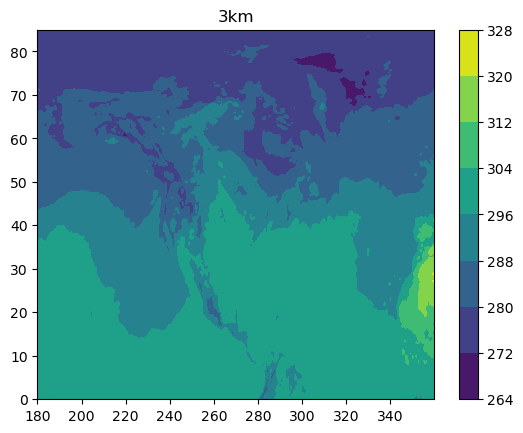

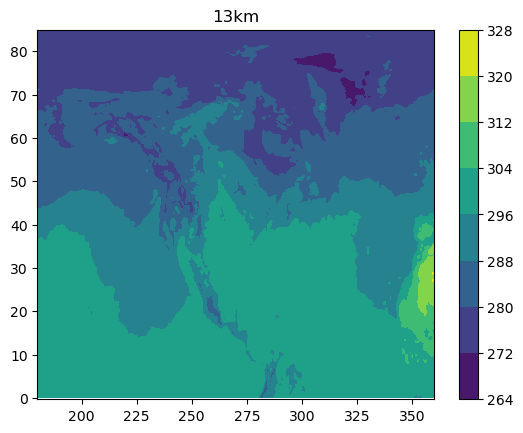

In [28]:
new_grids = {}

for m in [3, 13]:
    mg = xr.open_dataset(f'output_tests/UFS_test_regrid_{m}km.nc')

    vars = list(mg.variables)
    #print(vars)
    
    new_grids[m] = mg
    plt.contourf(mg[vars[0]], mg[vars[1]], mg[vars[-1]])
    plt.title(f'{m}km')
    plt.colorbar()
    plt.show()
    

In [32]:
def generate_plot(ds, m, extent):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,10), constrained_layout=True)   

    ax.set_extent(extent, crs = ccrs.PlateCarree())                                                                   # Set the extent according to above;; we love a good Great Lake
    ax.add_feature(cf.STATES, linewidth=1.5, edgecolor='black', alpha = 0.3)                                          # Add state boundaries 
    ax.coastlines(zorder = 10, linewidths = 1.5, color='black', alpha = 0.5)                                          # Add coastlines
    
    gl = ax.gridlines(color = 'lightgrey', draw_labels=True, linewidths = 1.5, x_inline=False, y_inline=False)        # Add the gridlines and the lat/lon labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'rotation': 0}
    gl.ylabel_style = {'size': 14, 'rotation': 0}
    gl.ylocator = mticker.FixedLocator(np.arange(10, 80, 10))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,40, 20))
    gl.top_labels    = False
    gl.right_labels  = False
    gl.left_labels   = True
    gl.bottom_labels = True


    vars = list(ds.variables)
    
    ax.pcolormesh(ds[vars[0]], ds[vars[1]], ds[vars[-1]], transform = ccrs.PlateCarree(), cmap = 'viridis', zorder=1, vmin = 240, vmax = 295)
    plt.title(f'{m}km')
    plt.show()

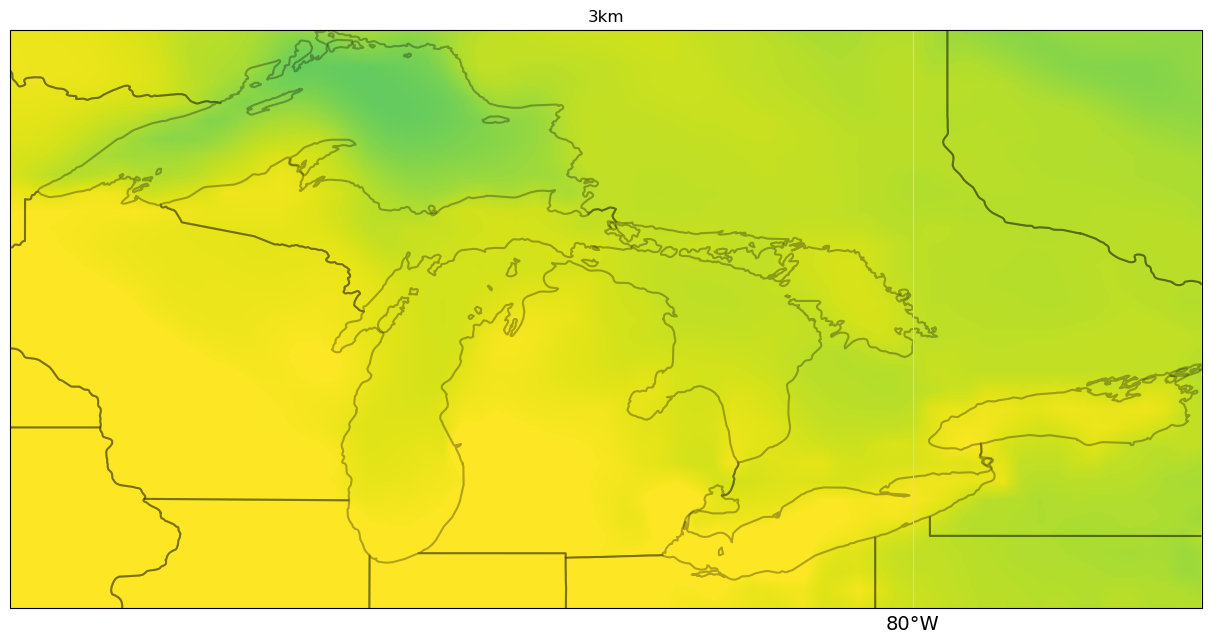

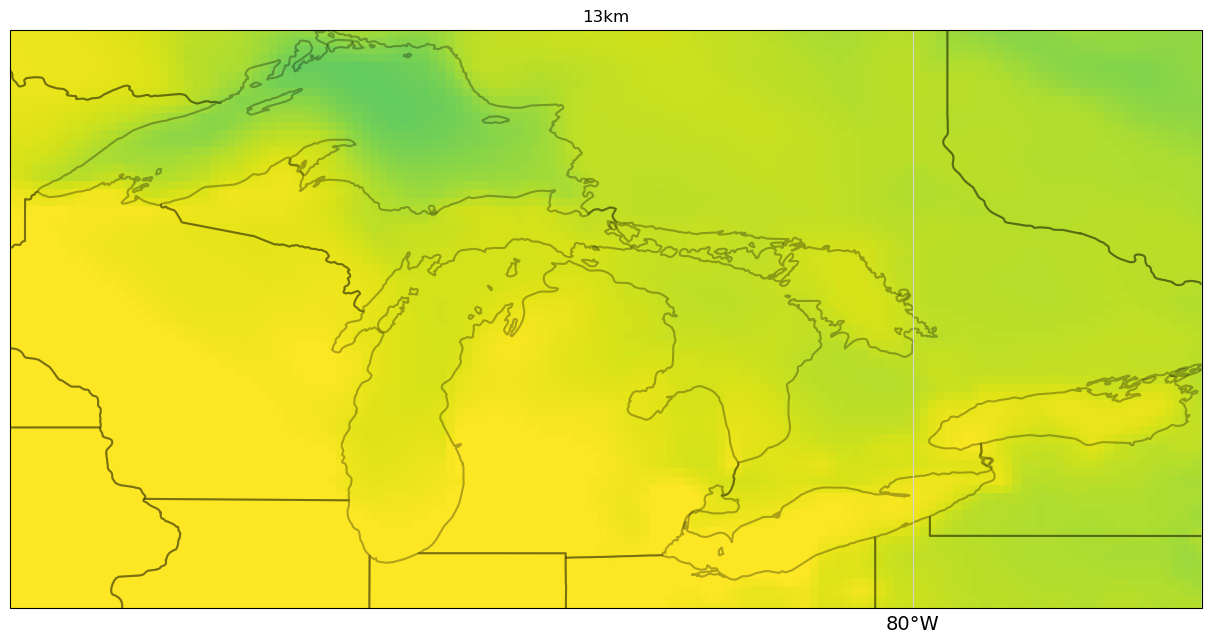

In [33]:
for m in [3,13]:
    generate_plot(new_grids[m],m, [-92.5, -76, 41, 49])

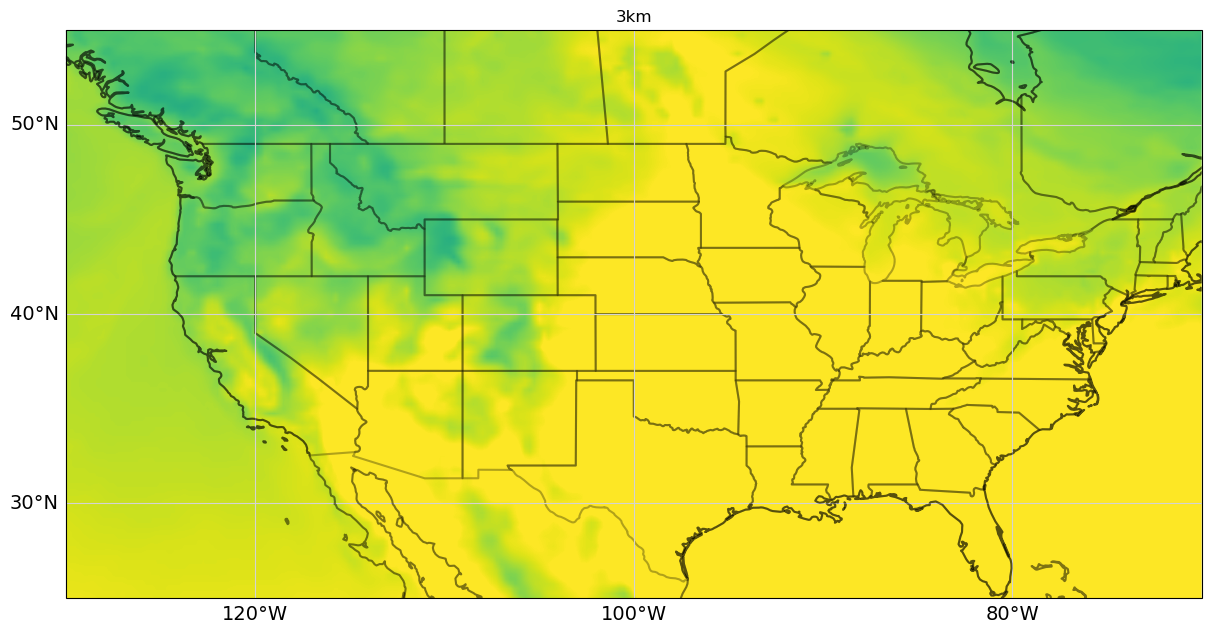

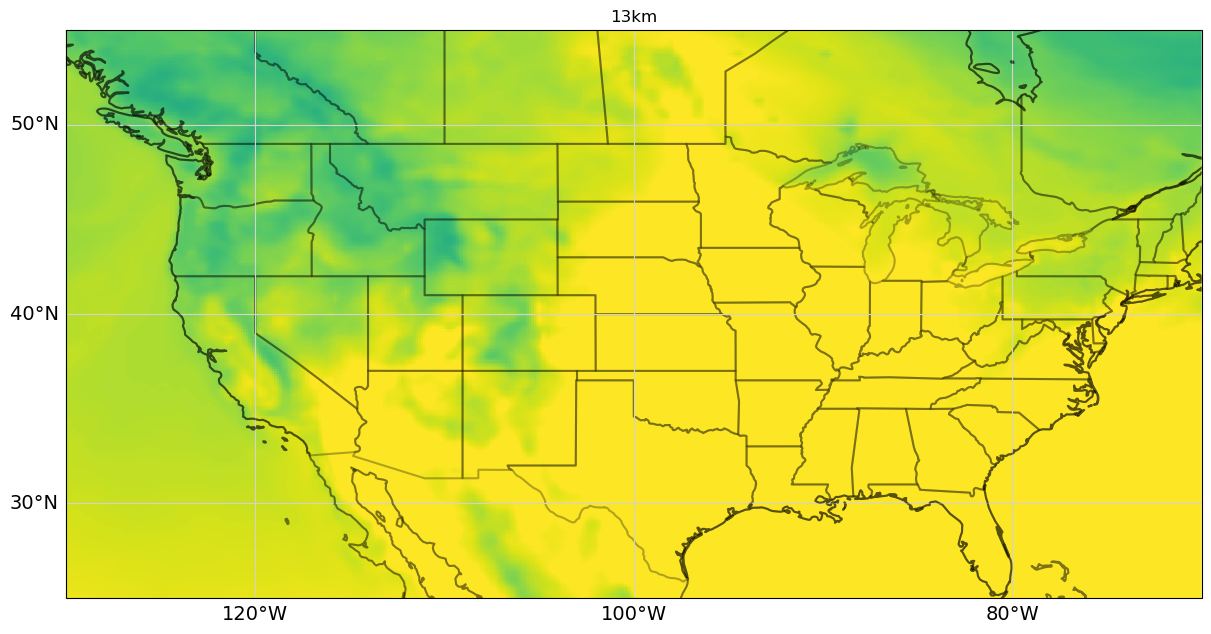

In [34]:
for m in [3, 13]:
    generate_plot(new_grids[m],m, [-130, -70, 25, 55])

# Prep new subdirectories 

In [1]:
import os

In [3]:
inits = os.listdir('../../../database_files/UFS_S2S/MPM/')

In [4]:
for i in inits:
    os.mkdir(f'../../../UFS_Downscaled/Statistical/13km/MPM/{i}')
    os.mkdir(f'../../../UFS_Downscaled/Statistical/3km/MPM/{i}')

# Now loop through all files!

# bash script for terminal to loop over all files. 

in the terminal:

    vi name_of_sh_file.sh

        paste the text in
        adjust the path names accordingly
        press :wq to save the file

    chmod +x name_of_sh_file.sh
    ./name_of_sh_file.sh

and your loop will be off! 

In [ ]:
#!/bin/bash

# Define the source and destination directories
src_dir="../../../database_files/UFS_S2S/MPM"
dest_dir="../../../UFS_Downscaled/Statistical/13km/MPM"

# Use find to recursively search for .nc files in the source directory
find "$src_dir" -type f -name "*.nc" | while read -r file; do
    # Get the relative path of the file within the source directory
    rel_path="${file#$src_dir/}"
    
    # Construct the destination file path
    dest_file="$dest_dir/$rel_path"
    
    # Ensure the destination directory for this file exists
    dest_file_dir=$(dirname "$dest_file")
    mkdir -p "$dest_file_dir"
    
    # Check if the output file already exists
    if [ ! -f "$dest_file" ]; then
        # The output file does not exist, so run the cdo command
        cdo remapbil,grid_files/UFS_target_grid_13km.txt "$file" "$dest_file"
        echo "Processed: $file -> $dest_file"
    else
        # The output file exists, so skip this file
        echo "Output file $dest_file already exists, skipping..."
    fi
done

In [ ]:
cdo remapbil,grid_files/UFS_target_grid_13km.txt grid_files/example_UFS.nc output_tests/UFS_test_regrid_3km.nc


# use the Regrid_Check_n_Clean.ipynb to see if files were successful or some bandaid work needs done